In [1]:
# !pip install pysqlite3-binary
# __import__('pysqlite3')
# import sys
# sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
# !pip install chromadb
# !pip install langchain-chroma

In [2]:
!pip install tavily-python


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
from typing import Dict
from tavily import TavilyClient
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

In [31]:
OPENAI_API_KEY="voc-*"
TAVILY_API_KEY="tav*"

In [34]:
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=OPENAI_API_KEY,
#     api_key=os.getenv("OPENAI_API_KEY"),
)

In [35]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(
        api_key=TAVILY_API_KEY,
#         api_key=os.getenv("TAVILY_API_KEY"),
    )
    response = tavily_client.search(question)
    return response

**Breakpoints**

In [36]:
class State(MessagesState):
    question: str
    answer: str

In [37]:
llm_with_tools = llm.bind_tools([web_search])

In [38]:
def entry_point(state: State):
    question = state["question"]
    system_message = SystemMessage("You conduct web search to respond to user's questions")
    human_message = HumanMessage(question)
    messages = [system_message, human_message]
    return {"messages": messages}

In [39]:
def agent(state: State):
    messages = state["messages"]
    ai_message = llm_with_tools.invoke(messages)
    return {"messages": ai_message, "answer": ai_message.content}

In [40]:
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"

    return END

In [41]:
workflow = StateGraph(State)
workflow.add_node("entry_point", entry_point)
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode([web_search]))

workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "agent")
workflow.add_conditional_edges(
    source="agent", 
    path=router, 
    path_map=["tools", END]
)
workflow.add_edge("tools", "agent")

In [42]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["tools"], 
    checkpointer=memory
)

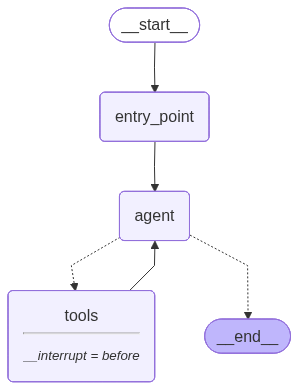

In [43]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [44]:
input_question = {"question": "what's the capital of Brazil?"}
config = {"configurable": {"thread_id": 1}}

In [45]:
for event in graph.stream(input=input_question, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_MKqkT6pI3O6vgQuIzJR04N7A)
 Call ID: call_MKqkT6pI3O6vgQuIzJR04N7A
  Args:
    question: What is the capital of Brazil?


In [46]:
state = graph.get_state(config=config)

In [47]:
state

StateSnapshot(values={'messages': [SystemMessage(content="You conduct web search to respond to user's questions", additional_kwargs={}, response_metadata={}, id='9d6c0f24-d12a-4b8c-bbcc-e1e6a44869d4'), HumanMessage(content="what's the capital of Brazil?", additional_kwargs={}, response_metadata={}, id='f72b2b18-f3c2-40c5-9e14-f0f5eb0885a8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MKqkT6pI3O6vgQuIzJR04N7A', 'function': {'arguments': '{"question":"What is the capital of Brazil?"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 64, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_11f3029f6b', 'finish_reason': 'tool_calls', 'logp

In [48]:
state.next

('tools',)

In [49]:
for event in graph.stream(input=None, config=config, stream_mode="values"):
    if not event['messages']:
        continue
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (call_MKqkT6pI3O6vgQuIzJR04N7A)
 Call ID: call_MKqkT6pI3O6vgQuIzJR04N7A
  Args:
    question: What is the capital of Brazil?
================================= Tool Message =================================
Name: web_search

{"query": "What is the capital of Brazil?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Capitals_of_Brazil", "title": "Capitals of Brazil", "content": "The city of Salvador served as the seat for the Portuguese colonial administration in Brazil for its first two centuries and is usually called the \"first capital of Brazil.\". + Salvador (1572–1578/1581) – capital city of the State of Maranhão. + Salvador (1621–1640) – capital city of the State of Bahia under the Iberian Union. * São Sebastião do Rio de Janeiro (1572–1578/1581) – capital city of the State of Brazil. * Rio de Janeiro (1763–1815) – 

**Human Approval**

In [54]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()
    
    human_input = input("Do you approve the tool calling? (YES or NO): ")
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    else:
        SystemMessage("Workflow aborted by a human").pretty_print()

In [55]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=2,
)

================================ Human Message =================================

what's the capital of Brazil?
================================ Human Message =================================

what's the capital of Brazil?


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_BkjlGBbslLBaZza6EPVhX9my", 'type': 'invalid_request_error', 'param': 'messages.[3].role', 'code': None}}

In [56]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Mexico?",
    thread_id=3,
)

================================== Ai Message ==================================

The capital of Mexico is Mexico City. It is the largest city in the country and serves as a major cultural, financial, and industrial hub. Mexico City is also the most populous city in North America.
================================ Human Message =================================

what's the capital of Mexico?
================================== Ai Message ==================================

The capital of Mexico is Mexico City.
Do you approve the tool calling? (YES or NO): YES
================================== Ai Message ==================================

The capital of Mexico is Mexico City.


**Human Revision**

In [57]:
memory = MemorySaver()
graph = workflow.compile(
    interrupt_before=["agent"], 
    checkpointer=memory
)

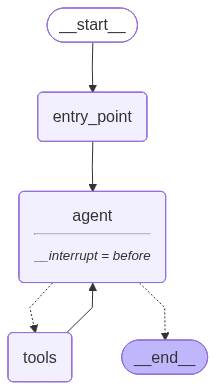

In [58]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [59]:
def human_in_the_loop_run(graph:CompiledStateGraph, question:str, thread_id:int):
    input_question = {"question": question}
    config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=input_question, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you want to proceed with this question? (YES or NO): ")
    
    if human_input.lower() == "no":
        human_input = input("So what should be the question? ")
        human_message = HumanMessage(content=human_input)
        system_message = SystemMessage("Workflow edited by a human")
        system_message.pretty_print()
        graph.update_state(
            config=config,
            values={
                "messages": [
                    system_message,
                    human_message,
                ]
            },
        )

        for event in graph.stream(input=None, config=config, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    
    for event in graph.stream(input=None, config=config, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()


In [60]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=4,
)

================================ Human Message =================================

what's the capital of Brazil?
Do you want to proceed with this question? (YES or NO): YES
================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_IOMAD5ZBI0hU9FRcBW0f6egi)
 Call ID: call_IOMAD5ZBI0hU9FRcBW0f6egi
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Capitals_of_Brazil", "title": "Capitals of Brazil", "content": "The city of Salvador served as the seat for the Portuguese colonial administration in Brazil for its first two centuries and is usually called the \"first capital of Brazil.\". + Salvador (1572–

In [61]:
human_in_the_loop_run(
    graph=graph,
    question="what's the capital of Brazil?",
    thread_id=5,
)

================================ Human Message =================================

what's the capital of Brazil?
Do you want to proceed with this question? (YES or NO): YES
================================ Human Message =================================

what's the capital of Brazil?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_uUz4IA05LHa9qA5yzEcEVjvA)
 Call ID: call_uUz4IA05LHa9qA5yzEcEVjvA
  Args:
    question: capital of Brazil
================================= Tool Message =================================
Name: web_search

{"query": "capital of Brazil", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Capitals_of_Brazil", "title": "Capitals of Brazil", "content": "The city of Salvador served as the seat for the Portuguese colonial administration in Brazil for its first two centuries and is usually called the \"first capital of Brazil.\". + Salvador (1572–